In [264]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random
import parallelproj
from scipy.ndimage import gaussian_filter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [265]:
#Set Random Seed for Reproducibility 
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_random_seed(1)

In [266]:
# Parameters 
num_samples = 5000
img_size = (128, 128)
detector_bins = 128
total_counts = 1e6  #Adjust to simulate realistic counts
res_factor = 1.5  #Resolution factor for Gaussian blurring
mu = 0.096  #Linear attenuation coefficient of water in 511keV
ct_noise_factor = 0.01  #Noise level for CT projections

r = np.linspace(-1, 1, img_size[0])
theta = np.linspace(0, np.pi, detector_bins, endpoint=False)  #Projection angles

#Projection Operator 
proj = parallelproj.ParallelViewProjector2D(
    (detector_bins, detector_bins), r, -theta,
    2 * float(np.max(r)), (float(np.min(r)), float(np.min(r))),
    (float(r[1] - r[0]), float(r[1] - r[0]))
)

In [267]:
#"anatomy"-function 
def generate_anatomy(shape=img_size, num_ellipsoids=4):
    img = torch.zeros(shape, dtype=torch.float32, device=device)
    grid_x, grid_y = torch.meshgrid(
        torch.linspace(-1, 1, shape[0], device=device),
        torch.linspace(-1, 1, shape[1], device=device),
        indexing="ij"
    )

    for _ in range(num_ellipsoids):
        center = torch.tensor([np.random.uniform(-0.5, 0.5), np.random.uniform(-0.5, 0.5)], device=device)
        radii = torch.tensor([np.random.uniform(0.2, 0.4), np.random.uniform(0.2, 0.4)], device=device)
        ellipsoid = (((grid_x - center[0]) / radii[0]) ** 2 + ((grid_y - center[1]) / radii[1]) ** 2) <= 1
        intensity = torch.rand(1, device=device) * 0.8 + 0.2
        img[ellipsoid] = intensity

    return img

In [268]:
def generate_pet_image(anatomy, num_tumors=1):
    pet_img = anatomy * 0.7  #copy with lower intensity 
    shape = anatomy.shape
    grid_x, grid_y = torch.meshgrid(
        torch.linspace(-1, 1, shape[0], device=device),
        torch.linspace(-1, 1, shape[1], device=device),
        indexing="ij"
    )

    #tumor Placement
    anatomy_mask = anatomy > 0
    valid_x, valid_y = torch.where(anatomy_mask)
    for _ in range(num_tumors):
        if valid_x.numel() == 0: continue
        idx = np.random.randint(0, valid_x.numel())
        center = torch.tensor([(valid_x[idx].item() / shape[0]) * 2 - 1, (valid_y[idx].item() / shape[1]) * 2 - 1], device=device)
        radii = torch.tensor([np.random.uniform(0.05, 0.02), np.random.uniform(0.05, 0.02)], device=device)
        tumor = (((grid_x - center[0]) / radii[0]) ** 2 + ((grid_y - center[1]) / radii[1]) ** 2) <= 1
        tumor = tumor & anatomy_mask
        intensity = torch.rand(1, device=device) * 0.8 + 0.5
        pet_img[tumor] = intensity

    return torch.clamp(pet_img, 0, 1)

In [269]:
# Dataset 
class PETCTDataset(Dataset):
    def __init__(self, num_samples=num_samples, img_size=img_size):
        self.num_samples = num_samples
        self.img_size = img_size
        self.pet_images = []
        self.ct_images = []
        self.pet_projections_clean = []  
        self.ct_projections_clean = []
        self.processed_pet_projections = []  # Store processed PET projections
        self.processed_ct_projections = []  # Store noisy CT projections

        for _ in range(num_samples):
            anatomy = generate_anatomy(self.img_size)
            ct_image = anatomy  # CT = full anatomy
            pet_image = generate_pet_image(anatomy)  # PET = anatomy + tumor

            # --- Forward Projection ---
            pet_projection = proj(pet_image.cpu().numpy())  # Convert to NumPy for Radon transform
            ct_projection = proj(ct_image.cpu().numpy())  # CT forward projection
            
            # Store NOISELESS projections
            self.pet_projections_clean.append(torch.tensor(pet_projection, dtype=torch.float32, device=device))
            self.ct_projections_clean.append(torch.tensor(ct_projection, dtype=torch.float32, device=device))
            
            # --- Apply PET Effects ---# --- Apply PET Effects ---
            image_fwd_att = np.exp(-mu * proj(ct_image.cpu().numpy()))  # Attenuation effect

            # Clip attenuation values to prevent division errors
            image_fwd_att = np.clip(image_fwd_att, 1e-6, None)  

            # Apply attenuation to PET projection
            emission_image_fwd = image_fwd_att * pet_projection  

            # Add Background Contamination (Simulating Scatter)
            contamination = np.full(emission_image_fwd.shape, 0.1 * np.mean(emission_image_fwd))

            # Apply Blurring
            for i in range(emission_image_fwd.shape[1]):
                emission_image_fwd[:, i] = gaussian_filter(emission_image_fwd[:, i], res_factor)

            # Ensure non-negative values before scaling
            emission_image_fwd = np.clip(emission_image_fwd, 0, None)

            # Scale total counts
            count_fac = total_counts / max(float(np.sum(emission_image_fwd)), 1e-6)  # Avoid division by zero
            emission_image_fwd *= count_fac
            contamination *= count_fac

            # Apply Poisson Noise (Ensure all values are non-negative)
            emission_image_fwd = np.clip(emission_image_fwd, 0, None)
            emission_image_fwd = np.random.poisson(emission_image_fwd).astype(np.float32)

            # Correct for attenuation (Avoid division by near-zero values)
            image_fwd_corr = (emission_image_fwd - contamination) / image_fwd_att
            image_fwd_corr = np.clip(image_fwd_corr, 0, None)  # Final clipping to avoid issues

            # --- Apply Noise to CT Projection ---
           # Ensure non-negative values before applying Poisson noise
            ct_projection = np.clip(ct_projection, 0, None)  

            # Apply Poisson noise (Poisson-distributed values drawn directly from the sinogram)
            noisy_ct_projection = np.random.poisson(ct_projection / ct_noise_factor) * ct_noise_factor

            # Store results
            self.pet_images.append(pet_image)
            self.ct_images.append(ct_image)
            self.processed_pet_projections.append(torch.tensor(image_fwd_corr, dtype=torch.float32, device=device))
            self.processed_ct_projections.append(torch.tensor(noisy_ct_projection, dtype=torch.float32, device=device))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return (
            self.pet_images[idx],                  #original PET image
            self.ct_images[idx],                   #original CT image
            self.processed_pet_projections[idx],   #noisy PET projection
            self.processed_ct_projections[idx],    #noisy CT projection
            self.pet_projections_clean[idx],       #clean PET sinogram
            self.ct_projections_clean[idx]         #clean CT sinogram
        )

#Create Dataset and DataLoader
set_random_seed(1)
dataset = PETCTDataset(num_samples=5000) # Set the sample size 
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)




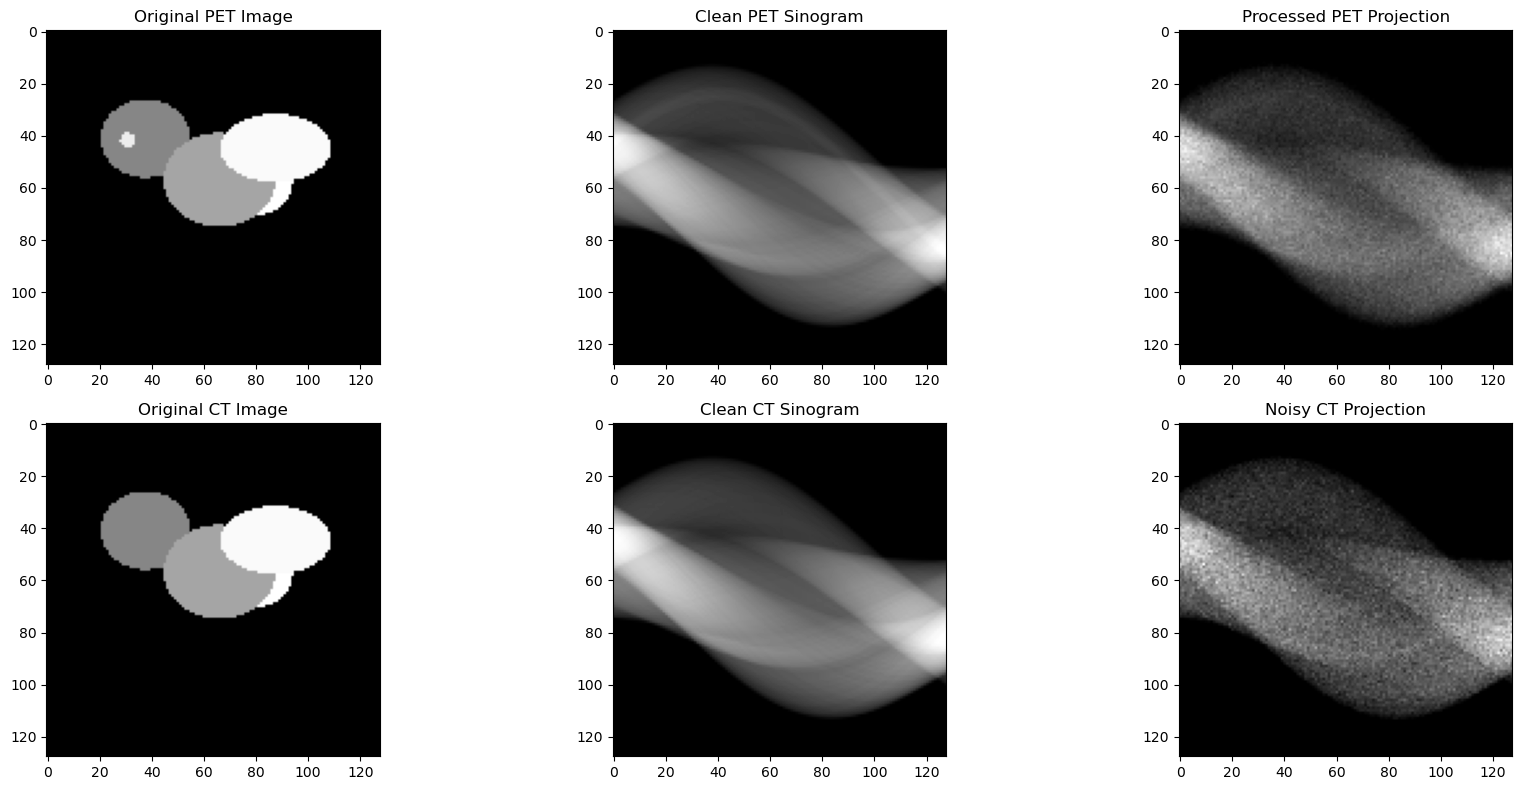

In [270]:
# visualize first sample 
pet_sample, ct_sample, processed_pet, processed_ct, pet_sinogram_clean, ct_sinogram_clean = dataset[0]

fig, ax = plt.subplots(2, 3, figsize=(18, 8))

# PET
ax[0, 0].imshow(pet_sample.cpu().numpy(), cmap="gray")
ax[0, 0].set_title("Original PET Image")
ax[0, 1].imshow(pet_sinogram_clean.cpu().numpy(), cmap="gray")
ax[0, 1].set_title("Clean PET Sinogram") 
ax[0, 2].imshow(processed_pet.cpu().numpy(), cmap="gray")
ax[0, 2].set_title("Processed PET Projection") 

# CT
ax[1, 0].imshow(ct_sample.cpu().numpy(), cmap="gray")
ax[1, 0].set_title("Original CT Image")
ax[1, 1].imshow(ct_sinogram_clean.cpu().numpy(), cmap="gray")
ax[1, 1].set_title("Clean CT Sinogram") 
ax[1, 2].imshow(processed_ct.cpu().numpy(), cmap="gray")
ax[1, 2].set_title("Noisy CT Projection")

plt.tight_layout()
plt.show()
